# Regression (MHC diversity (I, II) vs CH risk)

# Set up 

In [1]:
# IMPORTS

import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
from scipy import integrate
import scipy.integrate as it
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import plotly.express as px
import kaleido


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# specify font for plotting 
plt.rcParams.update({'font.sans-serif':'Helvetica'})

# stop printing warnings 
import warnings
warnings.filterwarnings("ignore")

# get current date 
timestr = time.strftime("%Y%m%d") 

# FONTS
title_font = 14
xaxis_font = 18
yaxis_font = 18
xticks_font = 16
yticks_font = 16
legend_title = 18
legend_font = 16
text_font = 12

# COLORS
col_het = '#48C9B0'
col_hom = '#E59866'
col_het2 = '#0ca083'
col_hom2 = '#be4e05'
col_1 = '#BA4A00'
col_2 = '#E59866'
col_3 = '#F6DDCC'
col_4 = '#D1F2EB'
col_5 = '#48C9B0'
col_6 = '#148F77'

col_005 = '#5DADE2'
col_001 = '#DF1A17'
col_ns = '#17202A'

# Read in dataframes 

In [5]:
# first, read in the file with scores (CH status = 1 == having >= 2 reads)
df_hla1 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/results/dataframes/20240907_df_hla1_ch_status.csv')
df_hla2 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/results/dataframes/20240907_df_hla2_ch_status.csv')


In [6]:
df_hla1

,Unnamed: 0,Person_ID,A_101,A_102,A_103,A_201,A_202,A_203,A_205,A_206,...,het_allele_I_C,count_class_I,sum_class_I,het_all_class_I,het_all_class_I_from_allele,VAF,gene_var,depth,var_depth,ch_status
0,0,2812213,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,True,5,6.0,False,False,NaN,NaN,NaN,NaN,0
1,1,4860169,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,5,6.0,False,False,NaN,NaN,NaN,NaN,0
2,2,3381323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,6,6.0,True,True,NaN,NaN,NaN,NaN,0
3,3,2805252,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,5,6.0,False,False,NaN,NaN,NaN,NaN,0
4,4,1118855,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,True,6,6.0,True,True,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413052,413052,3996965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,True,6,6.0,True,True,NaN,NaN,NaN,NaN,0
413053,413053,5660850,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,6,6.0,True,True,NaN,NaN,NaN,NaN,0
413054,413054,3573995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,6,6.0,True,True,NaN,NaN,NaN,NaN,0
413055,413055,3025735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,6,6.0,True,True,NaN,NaN,NaN,NaN,0


In [7]:
# read in the dataframes with CH status = 1 defined as having  >= 3 reads 
df_hla1['ch_status_3reads'] = np.where(df_hla1['var_depth'] >= 3, 1, 0)
df_hla2['ch_status_3reads'] = np.where(df_hla2['var_depth'] >= 3, 1, 0)

In [8]:

# do not include scores or specific A / B / C alleles sb has 
subset_classI = [col for col in df_hla1.columns if col.startswith(('A_', 'B_', 'C_'))] # all class I alleles 
subset_classII = [col for col in df_hla2.columns if col.startswith(('D'))] # all class II alleles 

df_hla1 = df_hla1.drop(subset_classI, axis = 1)
df_hla2 = df_hla2.drop(subset_classII, axis = 1)

df_hla2

,Unnamed: 0,Person_ID,age,allele_II_DRB,allele_II_DPA,allele_II_DPB,allele_II_DQA,allele_II_DQB,het_allele_II_DRB,het_allele_II_DPA,...,count_class_II_drb,sum_class_II,het_all_class_II,het_all_class_II_from_allele,VAF,gene_var,depth,var_depth,ch_status,ch_status_3reads
0,0,4860169,46.0,"DRB1_301, DRB1_1501",DPA1_103,"DPB1_301, DPB1_401","DQA1_102, DQA1_501","DQB1_201, DQB1_602",True,False,...,9,16.0,False,False,NaN,NaN,NaN,NaN,0,0
1,1,3381323,52.0,"DRB1_101, DRB1_401",DPA1_103,"DPB1_201, DPB1_401","DQA1_101, DQA1_301","DQB1_302, DQB1_501",True,False,...,9,16.0,False,False,NaN,NaN,NaN,NaN,0,0
2,2,2805252,65.0,"DRB1_401, DRB1_1501","DPA1_103, DPA1_202","DPB1_101, DPB1_401","DQA1_102, DQA1_301","DQB1_301, DQB1_602",True,True,...,10,16.0,False,True,NaN,NaN,NaN,NaN,0,0
3,3,3318036,50.0,DRB1_701,DPA1_201,DPB1_1101,DQA1_201,DQB1_202,False,False,...,5,16.0,False,False,NaN,NaN,NaN,NaN,0,0
4,4,4120291,41.0,"DRB1_103, DRB1_701",DPA1_201,"DPB1_1001, DPB1_1101","DQA1_101, DQA1_201","DQB1_202, DQB1_501",True,False,...,9,16.0,False,False,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352244,352244,4478244,55.0,"DRB1_1104, DRB1_1501",DPA1_103,"DPB1_301, DPB1_402","DQA1_102, DQA1_501","DQB1_301, DQB1_602",True,False,...,9,16.0,False,False,0.018692,DNMT3A_P904Q,107.0,2.0,1,0
352245,352245,4478244,55.0,"DRB1_1104, DRB1_1501",DPA1_103,"DPB1_301, DPB1_402","DQA1_102, DQA1_501","DQB1_301, DQB1_602",True,False,...,9,16.0,False,False,0.022727,DNMT3A_R882H,88.0,2.0,1,0
352246,352246,3573995,62.0,DRB1_301,DPA1_103,DPB1_401,DQA1_501,DQB1_201,False,False,...,5,16.0,False,False,NaN,NaN,NaN,NaN,0,0
352247,352247,3025735,51.0,"DRB1_404, DRB1_1101",DPA1_103,"DPB1_201, DPB1_401","DQA1_301, DQA1_501","DQB1_301, DQB1_402",True,False,...,9,16.0,False,False,NaN,NaN,NaN,NaN,0,0


In [11]:
len(df_hla2[(df_hla2['var_depth']>=3) & (~df_hla2['gene_var'].isna())].Person_ID.unique())

3891

# Plots (% of heterozygotes and distribution of the number of alleles)

In [12]:

# specify columns you want to include 
cols1 = ['het_all_class_I_from_allele', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C'] 
cols2 = ['het_all_class_II_from_allele', 'het_allele_II_DRB', 'het_allele_II_DQB', 'het_allele_II_DQA', 'het_allele_II_DPB', 'het_allele_II_DPA']

labels1 = ['class I', 'class I A', 'class I B', 'class I C']
labels2 = ['class II', 'class II DRB1', 'class II DQB', 'class II DQA', 'class II DPB', 'class II DPA']

sum_het1 = [df_hla1[col].sum() for col in cols1]
total1 = len(df_hla1['Person_ID'].unique())
percent_het1 = [s / total1 * 100 for s in sum_het1]
percent_hom1 = [100 - p for p in percent_het1]

sum_het2 = [df_hla2[col].sum() for col in cols2]
total2 = len(df_hla2['Person_ID'].unique())
percent_het2 = [s / total2 * 100 for s in sum_het2]
percent_hom2 = [100 - p for p in percent_het2]

df_percents1 = pd.DataFrame([percent_het1, percent_hom1, labels1]).T
df_percents1.columns = ['percent_heterozygous', 'percent_homozygous', 'label']

df_percents2 = pd.DataFrame([percent_het2, percent_hom2, labels2]).T
df_percents2.columns = ['percent_heterozygous', 'percent_homozygous', 'label']

df_percents = pd.concat([df_percents1, df_percents2], axis = 0)
df_percents

,percent_heterozygous,percent_homozygous,label
0,77.106279,22.893721,class I
1,85.150288,14.849712,class I A
2,92.097,7.903,class I B
3,89.594468,10.405532,class I C
0,26.242652,73.757348,class II
1,89.817853,10.182147,class II DRB1
2,88.229929,11.770071,class II DQB
3,82.206672,17.793328,class II DQA
4,75.094113,24.905887,class II DPB
5,32.509681,67.490319,class II DPA


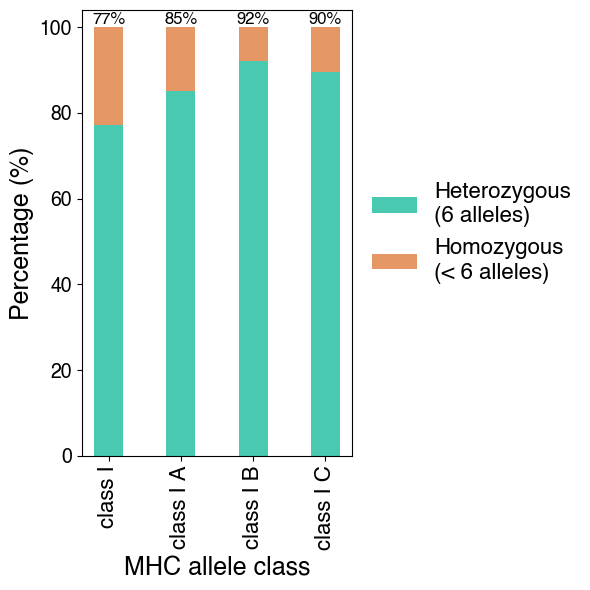

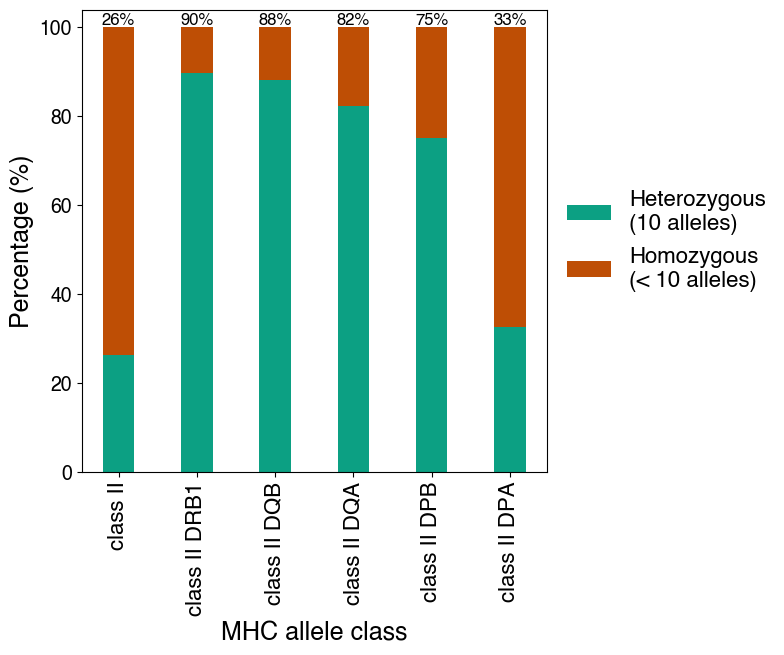

In [13]:
# plot 1 
colors = [col_het, col_hom]

plt.figure(figsize=(6, 6))

bar_width = 0.4
bar_positions = range(len(df_percents1))
bars_het = plt.bar(bar_positions, df_percents1['percent_heterozygous'], color=colors[0], width=bar_width, label='Heterozygous') # het at the bottom
bars_hom = plt.bar(bar_positions, df_percents1['percent_homozygous'], color=colors[1], width=bar_width, label='Homozygous', bottom=df_percents1['percent_heterozygous']) # stack het on hom

plt.xticks(bar_positions, df_percents1['label'], fontsize = xticks_font, rotation = 90)
plt.yticks(fontsize = yticks_font-2)
plt.xlabel('MHC allele class', fontsize = xaxis_font)
plt.ylabel('Percentage (%)', fontsize = yaxis_font)
plt.ylim(0, 104)

for bar1, bar2, percent_1 in zip(bars_het, bars_hom, df_percents1['percent_heterozygous']):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{round(percent_1)}%', 
             ha='center', va='bottom', fontsize=text_font, color='black')

plt.legend(['Heterozygous\n(6 alleles)', 'Homozygous\n(< 6 alleles)'], frameon = False, fontsize = legend_font, markerscale = 1, loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1a_percent_heterozygous_across_MHC_allele_classI.pdf', bbox_inches='tight')

# plot 2: class II MHC 
plt.tight_layout()
plt.figure(figsize=(6, 6))
colors = [col_het2, col_hom2]

bar_width = 0.4
bar_positions = range(len(df_percents2))
bars_het = plt.bar(bar_positions, df_percents2['percent_heterozygous'], color=colors[0], width=bar_width, label='Heterozygous') # het at the bottom
bars_hom = plt.bar(bar_positions, df_percents2['percent_homozygous'], color=colors[1], width=bar_width, label='Homozygous', bottom=df_percents2['percent_heterozygous']) # stack het on hom

plt.xticks(bar_positions, df_percents2['label'], fontsize = xticks_font, rotation = 90)
plt.yticks(fontsize = yticks_font-2)
plt.xlabel('MHC allele class', fontsize = xaxis_font)
plt.ylabel('Percentage (%)', fontsize = yaxis_font)
plt.ylim(0, 104)

for bar1, bar2, percent_1 in zip(bars_het, bars_hom, df_percents2['percent_heterozygous']):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{round(percent_1)}%', 
             ha='center', va='bottom', fontsize=text_font, color='black')

plt.legend(['Heterozygous\n(10 alleles)', 'Homozygous\n(< 10 alleles)'], frameon = False, fontsize = legend_font, markerscale = 1, loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1a_percent_heterozygous_across_MHC_allele_classII.pdf', bbox_inches='tight')

In [14]:
# you also want to plot the number of alleles if we are at that you know 

# you want to prepare the datasets first 
df_counts1 = df_hla1.count_class_I.value_counts().reset_index()
df_counts2 = df_hla2.count_class_II_drb.value_counts().reset_index().sort_values(by = 'count_class_II_drb')

# add percentage values
df_counts1['percent'] = df_counts1['count'] / df_counts1['count'].sum() * 100
df_counts2['percent'] = df_counts2['count'] / df_counts2['count'].sum() * 100

df_counts1 = df_counts1.sort_values(by = 'count_class_I', ascending = True).reset_index()
df_counts2 = df_counts2.sort_values(by = 'count_class_II_drb', ascending = True).reset_index()


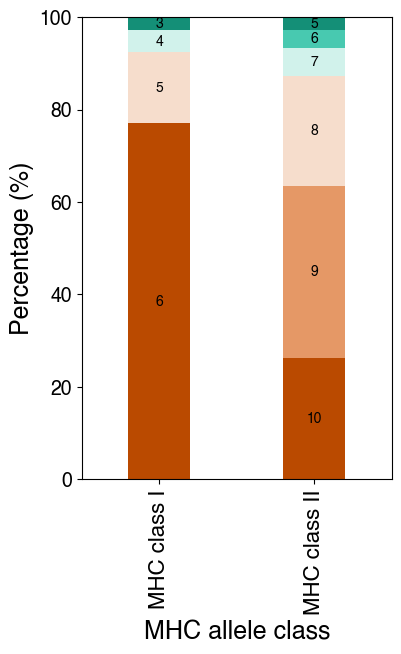

In [15]:
# the actual plot 
colors1 = [col_1, col_3, col_4, col_6]
colors2 = [col_1, col_2, col_3, col_4, col_5, col_6]

# okay now let's convert this to the stacked barplot 
plt.figure(figsize=(4, 6))

# plt.xticks(bar_positions, df_counts1['count_class_I'])
plt.xlabel('MHC allele class', fontsize = xaxis_font)
plt.ylabel('Percentage (%)', fontsize = yaxis_font)
plt.xticks(fontsize = xticks_font, rotation = 90)
plt.yticks(fontsize = yticks_font-2)
plt.ylim(0, 100)

bar_width = 0.4
bar_positions = [0, 1]
bars1_6 = plt.bar(0, df_counts1['percent'][3], color=colors1[0], width=bar_width, label='6 alleles') # het at the bottom
bars1_5 = plt.bar(0, df_counts1['percent'][2], color=colors1[1], width=bar_width, label='5 alleles', bottom = df_counts1['percent'][3]) # het at the bottom
bars1_4 = plt.bar(0, df_counts1['percent'][1], color=colors1[2], width=bar_width, label='4 alleles', bottom = df_counts1['percent'][3] + df_counts1['percent'][2]) # het at the bottom
bars1_3 = plt.bar(0, df_counts1['percent'][0], color=colors1[3], width=bar_width, label='3 alleles', bottom = df_counts1['percent'][3] + df_counts1['percent'][2] + df_counts1['percent'][1]) # het at the bottom

bars2_10 = plt.bar(1, df_counts2['percent'][5], color=colors2[0], width=bar_width, label='10 alleles') # het at the bottom
bars2_9 = plt.bar(1, df_counts2['percent'][4], color=colors2[1], width=bar_width, label='9 alleles', bottom = df_counts2['percent'][5]) # het at the bottom
bars2_8 = plt.bar(1, df_counts2['percent'][3], color=colors2[2], width=bar_width, label='8 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4]) # het at the bottom
bars2_7 = plt.bar(1, df_counts2['percent'][2], color=colors2[3], width=bar_width, label='7 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3]) # het at the bottom
bars2_6 = plt.bar(1, df_counts2['percent'][1], color=colors2[4], width=bar_width, label='6 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2]) # het at the bottom
bars2_5 = plt.bar(1, df_counts2['percent'][0], color=colors2[5], width=bar_width, label='5 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2] + df_counts2['percent'][1]) # het at the bottom

plt.text(0, df_counts1['percent'][3]/2, '6', ha='center', va='center', fontsize=10)
plt.text(0, df_counts1['percent'][3] + df_counts1['percent'][2]/2, '5', ha='center', va='center', fontsize=10)
plt.text(0, df_counts1['percent'][3] + df_counts1['percent'][2] + df_counts1['percent'][1]/2, '4', ha='center', va='center',fontsize=10)
plt.text(0, df_counts1['percent'][3] + df_counts1['percent'][2] + df_counts1['percent'][1] + df_counts1['percent'][0]/2, '3', ha='center', va='center', fontsize=10)

plt.text(1, df_counts2['percent'][5]/2, '10', ha='center', va='center', fontsize=10)
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4]/2, '9', ha='center', va='center', fontsize=10)
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3]/2, '8', ha='center', va='center', fontsize=10)
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2]/2, '7', ha='center', va='center', fontsize=10)
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2] + df_counts2['percent'][1]/2, '6', ha='center', va='center', fontsize=10)
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2] + df_counts2['percent'][1] + df_counts2['percent'][0]/2 , '5', ha='center', va='center', fontsize=10)

plt.xticks([0,1], ['MHC class I', 'MHC class II'], fontsize = xticks_font)
plt.xlim(-0.5, 1.5)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1b_percent_heterozygous_across_MHC_allele_classes_split_by_nr.pdf', bbox_inches='tight')

# Regression analysis 


### Additional phenotype data (age, sex, ancestry, smoking status)

In [16]:
# load datasets with phenotypic data (dataset from Hamish McGregor, sent on 28/02/2024)

pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/data/pheno_info20230504.tsv', sep = '\t')
ancestry_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/data/ukb_iadmix_ancestry_props.csv')

# make sure we have consistent naming for Person_ID column 
pheno_df = pheno_df.rename(columns={'ID_v0': 'Person_ID'}) 
ancestry_df = ancestry_df.rename(columns={'ukbid': 'Person_ID'}) 

# clean up datasets: IDs < 0 participants resigned from the study 
pheno_df = pheno_df[pheno_df.Person_ID > 0] # only retain participants with IDs greater than 0
ancestry_df = ancestry_df[ancestry_df.Person_ID > 0] # only retain participants with IDs greater than 0

# check how many people you have the data for
ids_pheno_data = pheno_df.Person_ID.unique()
ids_ancestry_data = ancestry_df.Person_ID.unique()

print('Number of people with phenotypic data available:', len(ids_pheno_data))
print('Number of people with ancestry data available:', len(ids_ancestry_data))

# identify people for whom both are available
ids_pheno_ancestry = set(ids_pheno_data).intersection(set(ids_ancestry_data)) # intersection 
print('Number of people with phenotypic and ancestry data available:', len(ids_pheno_ancestry))

Number of people with phenotypic data available: 502368
Number of people with ancestry data available: 502603
Number of people with phenotypic and ancestry data available: 502366


In [17]:
# identify people for whom you have ancestry, pheno AND MHC data are available 
ids_hla1 = df_hla1.Person_ID.unique()
ids_hla2 = df_hla2.Person_ID.unique()
ids_pheno_ancestry_hla1 = set(ids_pheno_ancestry).intersection(set(ids_hla1)) 
ids_pheno_ancestry_hla2 = set(ids_pheno_ancestry).intersection(set(ids_hla2)) 
ids_pheno_ancestry_hla1_2 = set(ids_pheno_ancestry_hla1).intersection(set(ids_hla2)) 
print('Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I:', len(ids_pheno_ancestry_hla1))
print('Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I:', len(ids_pheno_ancestry_hla2))
print('Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I AND II:', len(ids_pheno_ancestry_hla1_2))


Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I: 412704
Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I: 351933
Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I AND II: 322776


In [18]:
# create ancestry main column (need to convert to dummies dataframe)
ancestry_df_main = ancestry_df[['Person_ID', 'iadmix_main_ancestry_v2']]
ancestry_df_main['iadmix_main_ancestry_v2'] = pd.Categorical(ancestry_df_main['iadmix_main_ancestry_v2']) 
admix_dummies = pd.get_dummies(ancestry_df_main['iadmix_main_ancestry_v2'])
admix_dummies = admix_dummies.astype(int)
admix_df = pd.concat([ancestry_df_main, admix_dummies], axis=1)
admix_df = admix_df.drop('iadmix_main_ancestry_v2', axis = 1)

In [19]:
# Select features of interest 

# FEATURES: Age, Sex_v0, Genetic.sex_v0, Ever.smoked_v0, Ethnic.background_v0
# I know some other papers also look at the socio-economic index but not very possible to get it for this data

# create age column (age at attending assessment centre)
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Date.of.attending.assessment.centre_v0'].str.split('-').str[0] # determine year of attending assessment centre
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Year.of.birth_v0'] = pheno_df['Year.of.birth_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'] - pheno_df['Year.of.birth_v0'] # determine age when attended assessment centre
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Age.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 

features = ['Person_ID', 'Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'Ethnic.background_v0'] 
features_df = pheno_df[features]

# for binary outcomes, convert to 0 / 1
features_df['Sex_v0'] = features_df['Sex_v0'].replace({'Female': 0, 'Male': 1})
features_df['Ever.smoked_v0'] = features_df['Ever.smoked_v0'].replace({'Yes': 1, 'No': 0})

# for categorical data with no 1 / 0 levels, need to create dummies again 
ethnic_df = features_df[['Person_ID', 'Ethnic.background_v0']]
ethnic_df['Ethnic.background_v0'] = pd.Categorical(ethnic_df['Ethnic.background_v0']) 
ethnic_dummies = pd.get_dummies(ethnic_df['Ethnic.background_v0'])
ethnic_dummies = ethnic_dummies.astype(int) # we want to convert True / False to 1 / 0
ethnic_dummies = ethnic_dummies.drop(['Do not know', 'Prefer not to answer'], axis = 1)

# add ethnic data to other features 
features_df = pd.concat([features_df, ethnic_dummies], axis=1)
features_df = features_df.drop(['Ethnic.background_v0'], axis = 1) # drop columns with incorrect format / that would not be relevant 

# next, you need to add ancestry (admixture) data to this 
features_df = pd.merge(features_df, admix_df, on = 'Person_ID')

# drop missing 
features_df_eur = features_df[features_df['EUR']==1] # select european to not have to account for ancestry differences, also sorry but UKBB is v eur-biased 
features_df_clean = features_df_eur.dropna()  
print('Number of people with complete phenotypic features:', features_df_clean.shape[0])

Number of people with complete phenotypic features: 458811


In [20]:
# add MHC features 

# add MHC I features 
df_hla1_sub = df_hla1.replace({False: 0, True: 1}) # replace True / False with 1 / 0 to have this more systematically
df_hla1_sub = df_hla1_sub[df_hla1_sub['sum_class_I']==6] # remove people in whom not all MHC I alleles were typed (that does not mean they cannot be homozygous) (6 individuals with this)
df_hla1_features = pd.merge(features_df_clean, df_hla1_sub, on = 'Person_ID')
print('Number of observations (MHC I):', df_hla1_features.shape[0])

# add MHC II features 
df_hla2_sub = df_hla2.replace({False: 0, True: 1}) # replace True / False with 1 / 0 to have this more systematically
df_hla2_sub = df_hla2_sub[df_hla2_sub['sum_class_II']==16] # remove people in whom not all MHC II alleles were typed (that does not mean they cannot be homozygous) (16 individuals with this)
df_hla2_features = pd.merge(features_df_clean, df_hla2_sub, on = 'Person_ID')
print('Number of observations (MHC II):', df_hla2_features.shape[0])

df_hla1_2_features = pd.merge(df_hla1_features, df_hla2_sub, on = ['Person_ID', 'ch_status', 'gene_var', 'depth', 'var_depth', 'VAF'])
print('Number of observations (MHC I AND II):', df_hla1_2_features.shape[0])
df_hla1_2_features 

Number of observations (MHC I): 393024
Number of observations (MHC II): 336958
Number of observations (MHC I AND II): 311543


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,African,Any other Asian background,Any other Black background,Any other mixed background,Any other white background,Asian or Asian British,...,het_allele_II_DPA,het_allele_II_DPB,het_allele_II_DQA,het_allele_II_DQB,count_class_II,count_class_II_drb,sum_class_II,het_all_class_II,het_all_class_II_from_allele,ch_status_3reads_y
0,1000017,65.0,0,1.0,0,0,0,0,0,0,...,0,1,1,1,13,9,16.0,0,0,0
1,1000038,52.0,0,0.0,0,0,0,0,0,0,...,0,0,1,1,13,8,16.0,0,0,0
2,1000042,52.0,1,0.0,0,0,0,0,0,0,...,0,0,1,1,12,8,16.0,0,0,0
3,1000056,65.0,0,0.0,0,0,0,0,0,0,...,1,1,1,1,15,10,16.0,0,1,0
4,1000061,60.0,0,1.0,0,0,0,0,0,0,...,1,1,1,1,15,10,16.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311538,6026142,63.0,1,1.0,0,0,0,0,0,0,...,0,1,1,1,14,9,16.0,0,0,0
311539,6026156,68.0,1,1.0,0,0,0,0,0,0,...,0,1,1,1,13,9,16.0,0,0,0
311540,6026161,68.0,0,1.0,0,0,0,0,0,0,...,0,1,1,1,14,9,16.0,0,0,0
311541,6026189,66.0,0,0.0,0,0,0,0,0,0,...,1,1,1,1,14,10,16.0,0,1,0


In [22]:
# set column names to something nice to plot, much easier than trying to deal with this on matplotlib
df_hla1_features.rename(columns = {'count_class_I':'Number of distinct MHC I alleles'}, inplace = True)
df_hla1_features.rename(columns = {'het_allele_I_A':'MHC I A heterozygosity'}, inplace = True)
df_hla1_features.rename(columns = {'het_allele_I_B':'MHC I B heterozygosity'}, inplace = True)
df_hla1_features.rename(columns = {'het_allele_I_C':'MHC I C heterozygosity'}, inplace = True)
df_hla1_features.rename(columns = {'het_all_class_I':'MHC I heterozygosity (6 alleles)'}, inplace = True)

df_hla2_features.rename(columns = {'count_class_II_drb':'Number of distinct MHC II alleles'}, inplace = True)
df_hla2_features.rename(columns = {'het_allele_II_DRB':'MHC II DRB1 heterozygosity'}, inplace = True)
df_hla2_features.rename(columns = {'het_allele_II_DPA':'MHC II DPA heterozygosity'}, inplace = True)
df_hla2_features.rename(columns = {'het_allele_II_DPB':'MHC II DPB heterozygosity'}, inplace = True)
df_hla2_features.rename(columns = {'het_allele_II_DQA':'MHC II DQA heterozygosity'}, inplace = True)
df_hla2_features.rename(columns = {'het_allele_II_DQB':'MHC II DQB heterozygosity'}, inplace = True)
df_hla2_features.rename(columns = {'het_all_class_II':'MHC II heterozygosity (10 alleles)'}, inplace = True)


In [25]:
# Remove samples for which there is no age data 
df_hla1_features = df_hla1_features[~df_hla1_features['Age.of.attending.assessment.centre_v0'].isna()]
df_hla2_features = df_hla2_features[~df_hla2_features['Age.of.attending.assessment.centre_v0'].isna()]

## Regression (MHC I)

In [29]:
# REGRESSION

# create empty dictionaries to store coefficients in
dict_intercepts_mhci1 = {}
dict_coefficients_mhci1 = {}
dict_confints_mhci1 = {}
dict_pvalues_mhci1 = {}
dict_coefficients_mhci2 = {}
dict_confints_mhci2 = {}
dict_pvalues_mhci2 = {}
dict_coefficients_mhci3 = {}
dict_confints_mhci3 = {}
dict_pvalues_mhci3 = {}
dict_coefficients_mhci4 = {}
dict_confints_mhci4 = {}
dict_pvalues_mhci4 = {}

# the outcome that we are currently interested in is CH status (does someone have CH?)
outcome = 'ch_status'
 
# MODEL 1: NUMBER OF MHC I ALLELES 
# features for MODEL 1 (nr of MHC I alleles)
features1 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'Number of distinct MHC I alleles']  

# create dataframes with features and outcome 
X1 = df_hla1_features[features1]
y1 = df_hla1_features[outcome].astype('bool')

# run the model 
model1 = sm.Logit(y1, sm.add_constant(X1)) # the add_constant is here so the model also includes the intercept 
result1 = model1.fit(disp = 0)

# get parameters of interest 
intercept_multi1 = result1.params[0]
coeff_multi1 = result1.params
confint_multi1 = result1.conf_int()
pvalues_multi1 = result1.pvalues

dict_intercepts_mhci1[outcome] = intercept_multi1
dict_coefficients_mhci1[outcome] = coeff_multi1
dict_confints_mhci1[outcome] = confint_multi1
dict_pvalues_mhci1[outcome] = pvalues_multi1

# MODEL 2: MHC I heterozygosity (6 alleles vs < 6 alleles)
# features for MODEL 2 (looking at heterozygosity for particular loci)
features2 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'MHC I heterozygosity (6 alleles)'] 

X2 = df_hla1_features[features2]
y2 = df_hla1_features[outcome].astype('bool')

model2 = sm.Logit(y2, sm.add_constant(X2)) # the add_constant is here so the model also includes the intercept 
result2 = model2.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi2 = result2.params
confint_multi2 = result2.conf_int()
pvalues_multi2 = result2.pvalues

dict_coefficients_mhci2[outcome] = coeff_multi2
dict_confints_mhci2[outcome] = confint_multi2
dict_pvalues_mhci2[outcome] = pvalues_multi2

# MODEL 3: MHC I A, B, C heterozygosity 
# features for MODEL 3 (looking at heterozygosity for particular loci)
features3 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

X3 = df_hla1_features[features3]
y3 = df_hla1_features[outcome].astype('bool')

model3 = sm.Logit(y3, sm.add_constant(X3)) # the add_constant is here so the model also includes the intercept 
result3 = model3.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi3 = result3.params
confint_multi3 = result3.conf_int()
pvalues_multi3 = result3.pvalues

dict_coefficients_mhci3[outcome] = coeff_multi3
dict_confints_mhci3[outcome] = confint_multi3
dict_pvalues_mhci3[outcome] = pvalues_multi3

# MODEL 4: MHC I A, B, C heterozygosity + MHC I overall heterozygosity combined 
features4 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC I heterozygosity (6 alleles)', 'MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

X4 = df_hla1_features[features4]
y4 = df_hla1_features[outcome].astype('bool')

model4 = sm.Logit(y4, sm.add_constant(X4)) # the add_constant is here so the model also includes the intercept 
result4 = model4.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi4 = result4.params
confint_multi4 = result4.conf_int()
pvalues_multi4 = result4.pvalues

dict_coefficients_mhci4[outcome] = coeff_multi4
dict_confints_mhci4[outcome] = confint_multi4
dict_pvalues_mhci4[outcome] = pvalues_multi4


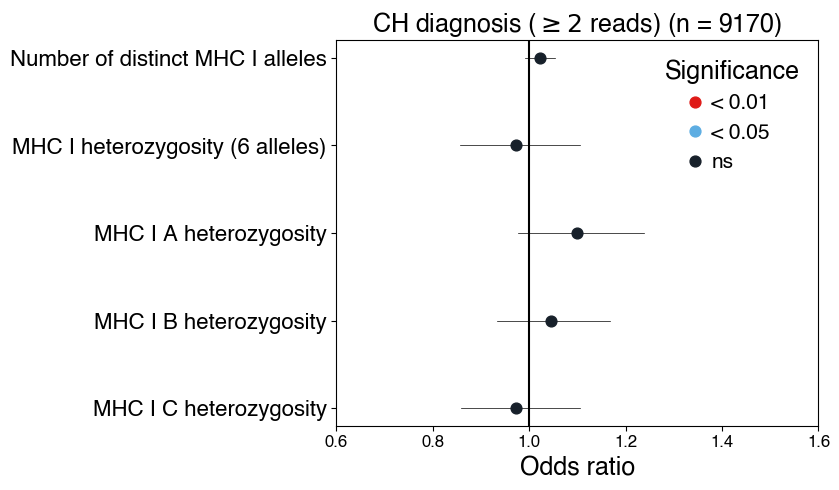

In [30]:
# PLOT (NR OF MHC ALLELES + COMBINED MODEL)

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhci1.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla1_features.ch_status.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 2$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci1[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci1[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhci1[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC I alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC I alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC I alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 4 results (MODEL 4 is combined specific MHC classes + overall)
for outcome_label, coef_dict in dict_coefficients_mhci4.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci4[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci4[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhci4[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC I heterozygosity (6 alleles)', 'MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 18)
    plt.xlim(0.6, 1.6)  
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, markerscale = 1.3, loc='upper right', title='Significance', handlelength = 0, fontsize = 15, title_fontsize = 18, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1c1_log_reg_mhci_vs_ch_combined.pdf', bbox_inches='tight')


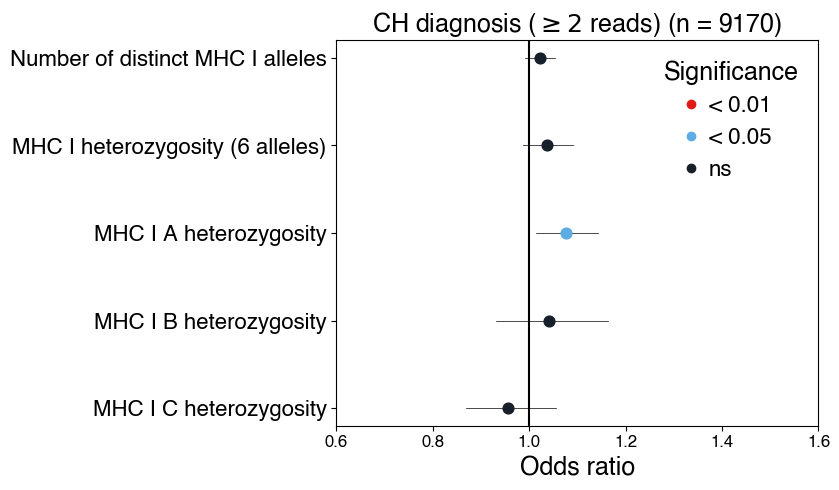

In [31]:
# PLOT (NR OF MHC ALLELES + OVERALL SPLIT MODEL)

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhci1.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla1_features.ch_status.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 2$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci1[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci1[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhci1[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC I alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC I alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC I alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 2 results (MODEL 2 is overall MHC)
for outcome_label, coef_dict in dict_coefficients_mhci2.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci2[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci2[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhci2[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC I heterozygosity (6 alleles)'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 3 results (MODEL 3 is MHC het for class A, B, C)
for outcome_label, coef_dict in dict_coefficients_mhci3.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci3[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci3[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhci3[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 15)
    plt.xlim(0.6, 1.6) 
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0, fontsize = legend_font, title_fontsize = legend_title, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1c1_log_reg_mhci_vs_ch_split_class_overall.pdf', bbox_inches='tight')


## Regression (MHC II)

In [32]:
# REGRESSION

# create empty dictionaries to store coefficients in
dict_intercepts_mhcii1 = {}
dict_coefficients_mhcii1 = {}
dict_confints_mhcii1 = {}
dict_pvalues_mhcii1 = {}
dict_coefficients_mhcii2 = {}
dict_confints_mhcii2 = {}
dict_pvalues_mhcii2 = {}
dict_coefficients_mhcii3 = {}
dict_confints_mhcii3 = {}
dict_pvalues_mhcii3 = {}
dict_coefficients_mhcii4 = {}
dict_confints_mhcii4 = {}
dict_pvalues_mhcii4 = {}

# the outcome that we are currently interested in is CH status (does someone have CH?)
outcome = 'ch_status'
 
# MODEL 1 
# features for MODEL 1 (nr of MHC I alleles)
features1 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'Number of distinct MHC II alleles']  

# create dataframes with features and outcome 
X1 = df_hla2_features[features1]
y1 = df_hla2_features[outcome].astype('bool')

# run the model 
model1 = sm.Logit(y1, sm.add_constant(X1)) # the add_constant is here so the model also includes the intercept 
result1 = model1.fit(disp = 0)

# get parameters of interest 
intercept_multi1 = result1.params[0]
coeff_multi1 = result1.params
confint_multi1 = result1.conf_int()
pvalues_multi1 = result1.pvalues

dict_intercepts_mhcii1[outcome] = intercept_multi1
dict_coefficients_mhcii1[outcome] = coeff_multi1
dict_confints_mhcii1[outcome] = confint_multi1
dict_pvalues_mhcii1[outcome] = pvalues_multi1

# MODEL 2: MHC I heterozygosity (6 alleles vs < 6 alleles)
# features for MODEL 2 (looking at heterozygosity for particular loci)
features2 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'MHC II heterozygosity (10 alleles)'] 

X2 = df_hla2_features[features2]
y2 = df_hla2_features[outcome].astype('bool')

model2 = sm.Logit(y2, sm.add_constant(X2)) # the add_constant is here so the model also includes the intercept 
result2 = model2.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi2 = result2.params
confint_multi2 = result2.conf_int()
pvalues_multi2 = result2.pvalues

dict_coefficients_mhcii2[outcome] = coeff_multi2
dict_confints_mhcii2[outcome] = confint_multi2
dict_pvalues_mhcii2[outcome] = pvalues_multi2

# MODEL 3: MHC I A, B, C heterozygosity 
# features for MODEL 2 (looking at heterozygosity for particular loci)
features3 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

X3 = df_hla2_features[features3]
y3 = df_hla2_features[outcome].astype('bool')

model3 = sm.Logit(y3, sm.add_constant(X3)) # the add_constant is here so the model also includes the intercept 
result3 = model3.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi3 = result3.params
confint_multi3 = result3.conf_int()
pvalues_multi3 = result3.pvalues

dict_coefficients_mhcii3[outcome] = coeff_multi3
dict_confints_mhcii3[outcome] = confint_multi3
dict_pvalues_mhcii3[outcome] = pvalues_multi3

# MODEL 4: MHC I A, B, C heterozygosity + MHC I overall heterozygosity combined 
features4 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC II heterozygosity (10 alleles)', 'MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

X4 = df_hla2_features[features4]
y4 = df_hla2_features[outcome].astype('bool')

model4 = sm.Logit(y4, sm.add_constant(X4)) # the add_constant is here so the model also includes the intercept 
result4 = model4.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi4 = result4.params
confint_multi4 = result4.conf_int()
pvalues_multi4 = result4.pvalues

dict_coefficients_mhcii4[outcome] = coeff_multi4
dict_confints_mhcii4[outcome] = confint_multi4
dict_pvalues_mhcii4[outcome] = pvalues_multi4

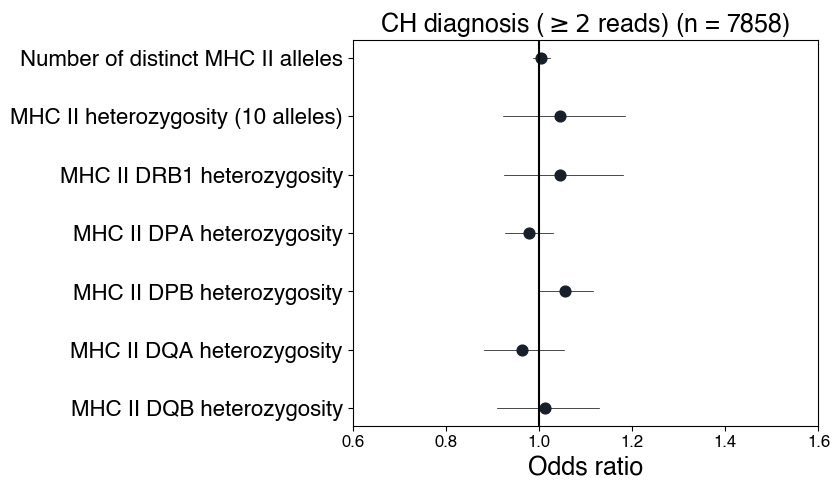

In [33]:
# REGRESSION PLOT

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhcii1.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla2_features.ch_status.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 2$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii1[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii1[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii1[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC II alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC II alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC II alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 2 results
for outcome_label, coef_dict in dict_coefficients_mhcii4.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii4[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii4[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii4[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC II heterozygosity (10 alleles)', 'MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 15)
    plt.xlim(0.6, 1.6) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    #plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0, fontsize = legend_font, title_fontsize = legend_title, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1c2_log_reg_mhcii_vs_ch_combined.pdf', bbox_inches='tight')


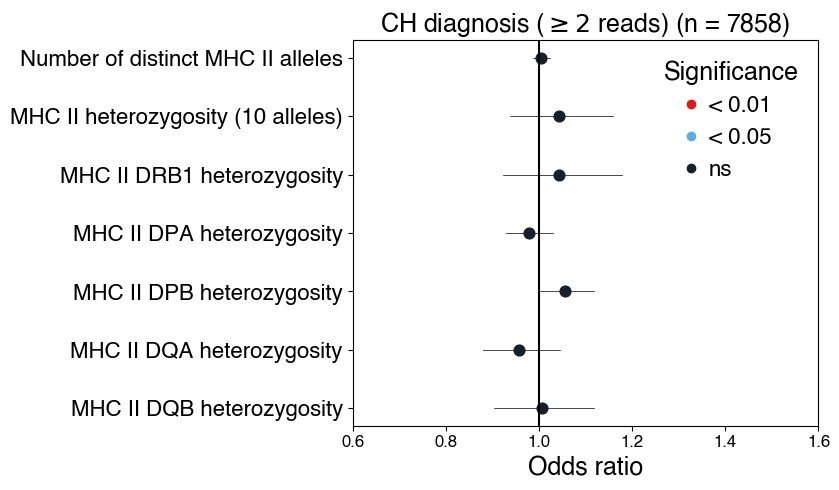

In [34]:
# PLOT (NR OF MHC ALLELES + OVERALL SPLIT MODEL)

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhcii1.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla2_features.ch_status.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 2$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii1[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii1[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii1[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC II alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC II alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC II alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 2 results (MODEL 2 is overall MHC)
for outcome_label, coef_dict in dict_coefficients_mhcii2.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii2[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii2[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii2[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC II heterozygosity (10 alleles)'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 3 results (MODEL 3 is MHC het for class A, B, C)
for outcome_label, coef_dict in dict_coefficients_mhcii3.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii3[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii3[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii3[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 15)
    plt.xlim(0.6, 1.6) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0, fontsize = legend_font, title_fontsize = legend_title, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1c2_log_reg_mhcii_vs_ch_split_class_overall.pdf', bbox_inches='tight')


# Analysis for CH defined with the threshold of 3 reads 

## Regression (MHC I)

In [35]:
# REGRESSION

# create empty dictionaries to store coefficients in
dict_intercepts_mhci1_3reads = {}
dict_coefficients_mhci1_3reads = {}
dict_confints_mhci1_3reads = {}
dict_pvalues_mhci1_3reads = {}
dict_coefficients_mhci2_3reads = {}
dict_confints_mhci2_3reads = {}
dict_pvalues_mhci2_3reads = {}
dict_coefficients_mhci3_3reads = {}
dict_confints_mhci3_3reads = {}
dict_pvalues_mhci3_3reads = {}
dict_coefficients_mhci4_3reads = {}
dict_confints_mhci4_3reads = {}
dict_pvalues_mhci4_3reads = {}

# the outcome that we are currently interested in is CH status (does someone have CH?)
outcome = 'ch_status_3reads'
 
# MODEL 1: NUMBER OF MHC I ALLELES 
# features for MODEL 1 (nr of MHC I alleles)
features1 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'Number of distinct MHC I alleles']  

# create dataframes with features and outcome 
X1 = df_hla1_features[features1]
y1 = df_hla1_features[outcome].astype('bool')

# run the model 
model1 = sm.Logit(y1, sm.add_constant(X1)) # the add_constant is here so the model also includes the intercept 
result1 = model1.fit(disp = 0)

# get parameters of interest 
intercept_multi1 = result1.params[0]
coeff_multi1 = result1.params
confint_multi1 = result1.conf_int()
pvalues_multi1 = result1.pvalues

dict_intercepts_mhci1_3reads[outcome] = intercept_multi1
dict_coefficients_mhci1_3reads[outcome] = coeff_multi1
dict_confints_mhci1_3reads[outcome] = confint_multi1
dict_pvalues_mhci1_3reads[outcome] = pvalues_multi1

# MODEL 2: MHC I heterozygosity (6 alleles vs < 6 alleles)
# features for MODEL 2 (looking at heterozygosity for particular loci)
features2 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'MHC I heterozygosity (6 alleles)'] 

X2 = df_hla1_features[features2]
y2 = df_hla1_features[outcome].astype('bool')

model2 = sm.Logit(y2, sm.add_constant(X2)) # the add_constant is here so the model also includes the intercept 
result2 = model2.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi2 = result2.params
confint_multi2 = result2.conf_int()
pvalues_multi2 = result2.pvalues

dict_coefficients_mhci2_3reads[outcome] = coeff_multi2
dict_confints_mhci2_3reads[outcome] = confint_multi2
dict_pvalues_mhci2_3reads[outcome] = pvalues_multi2

# MODEL 3: MHC I A, B, C heterozygosity 
# features for MODEL 2 (looking at heterozygosity for particular loci)
features3 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

X3 = df_hla1_features[features3]
y3 = df_hla1_features[outcome].astype('bool')

model3 = sm.Logit(y3, sm.add_constant(X3)) # the add_constant is here so the model also includes the intercept 
result3 = model3.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi3 = result3.params
confint_multi3 = result3.conf_int()
pvalues_multi3 = result3.pvalues

dict_coefficients_mhci3_3reads[outcome] = coeff_multi3
dict_confints_mhci3_3reads[outcome] = confint_multi3
dict_pvalues_mhci3_3reads[outcome] = pvalues_multi3

# MODEL 4: MHC I A, B, C heterozygosity + MHC I overall heterozygosity combined 
features4 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC I heterozygosity (6 alleles)', 'MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

X4 = df_hla1_features[features4]
y4 = df_hla1_features[outcome].astype('bool')

model4 = sm.Logit(y4, sm.add_constant(X4)) # the add_constant is here so the model also includes the intercept 
result4 = model4.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi4 = result4.params
confint_multi4 = result4.conf_int()
pvalues_multi4 = result4.pvalues

dict_coefficients_mhci4_3reads[outcome] = coeff_multi4
dict_confints_mhci4_3reads[outcome] = confint_multi4
dict_pvalues_mhci4_3reads[outcome] = pvalues_multi4


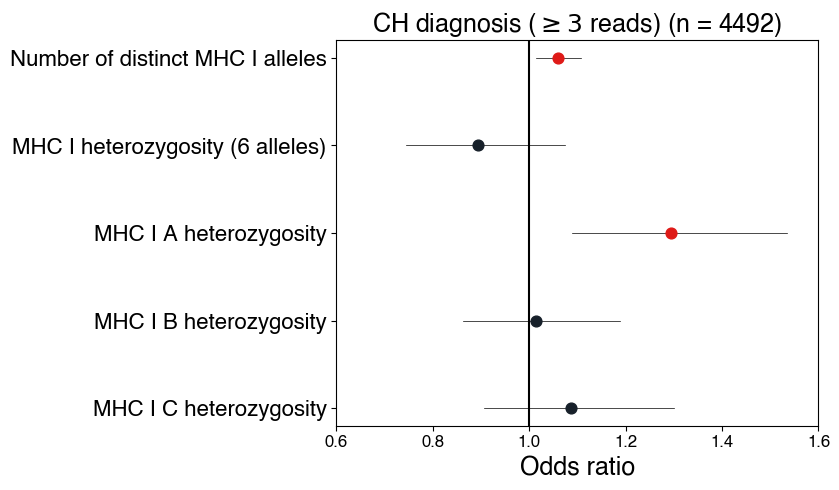

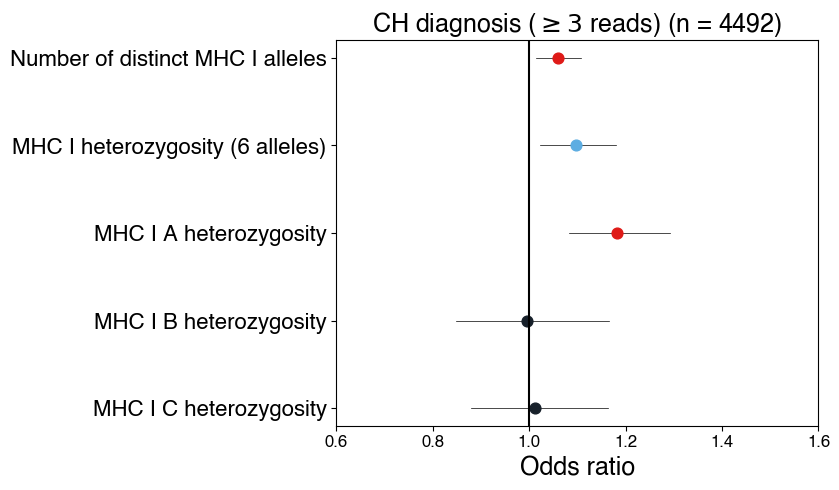

In [39]:
# PLOT (NR OF MHC ALLELES + COMBINED MODEL)

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhci1_3reads.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla1_features.ch_status_3reads.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 3$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci1_3reads[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci1_3reads[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhci1_3reads[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC I alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC I alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC I alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 4 results (MODEL 4 is combined specific MHC classes + overall)
for outcome_label, coef_dict in dict_coefficients_mhci4_3reads.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci4_3reads[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci4_3reads[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhci4_3reads[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC I heterozygosity (6 alleles)', 'MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 15)
    plt.xlim(0.6, 1.6)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    # plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0, fontsize = legend_font, title_fontsize = legend_title, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1d1_log_reg_mhci_vs_ch_combined_3reads.pdf', bbox_inches='tight')


# PLOT FOR SPLIT MHC LOCI + OVERALL HET
# PLOT (NR OF MHC ALLELES + OVERALL SPLIT MODEL)

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhci1_3reads.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla1_features.ch_status_3reads.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 3$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci1_3reads[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci1_3reads[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhci1_3reads[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC I alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC I alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC I alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 2 results (MODEL 2 is overall MHC)
for outcome_label, coef_dict in dict_coefficients_mhci2_3reads.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci2_3reads[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci2_3reads[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhci2_3reads[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC I heterozygosity (6 alleles)'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 3 results (MODEL 3 is MHC het for class A, B, C)
for outcome_label, coef_dict in dict_coefficients_mhci3_3reads.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhci3_3reads[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhci3_3reads[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhci3_3reads[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC I A heterozygosity', 'MHC I B heterozygosity', 'MHC I C heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 15)
    plt.xlim(0.6, 1.6) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    # plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0, fontsize = legend_font, title_fontsize = legend_title, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1d1_log_reg_mhci_vs_ch_split_class_overal_3reads.pdf', bbox_inches='tight')

# so now this is technically significant but 1) is this a real result? 2) it goes in the wrong direction anyway


## Regression (MHC II)

In [40]:
# REGRESSION

# create empty dictionaries to store coefficients in
dict_intercepts_mhcii1_3reads = {}
dict_coefficients_mhcii1_3reads = {}
dict_confints_mhcii1_3reads = {}
dict_pvalues_mhcii1_3reads = {}
dict_coefficients_mhcii2_3reads = {}
dict_confints_mhcii2_3reads = {}
dict_pvalues_mhcii2_3reads = {}
dict_coefficients_mhcii3_3reads = {}
dict_confints_mhcii3_3reads = {}
dict_pvalues_mhcii3_3reads = {}
dict_coefficients_mhcii4_3reads = {}
dict_confints_mhcii4_3reads = {}
dict_pvalues_mhcii4_3reads = {}

# the outcome that we are currently interested in is CH status (does someone have CH?)
outcome = 'ch_status_3reads'
 
# MODEL 1: NUMBER OF MHC I ALLELES 
# features for MODEL 1 (nr of MHC I alleles)
features1 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'Number of distinct MHC II alleles']  

# create dataframes with features and outcome 
X1 = df_hla2_features[features1]
y1 = df_hla2_features[outcome].astype('bool')

# run the model 
model1 = sm.Logit(y1, sm.add_constant(X1)) # the add_constant is here so the model also includes the intercept 
result1 = model1.fit(disp = 0)

# get parameters of interest 
intercept_multi1 = result1.params[0]
coeff_multi1 = result1.params
confint_multi1 = result1.conf_int()
pvalues_multi1 = result1.pvalues

dict_intercepts_mhcii1_3reads[outcome] = intercept_multi1
dict_coefficients_mhcii1_3reads[outcome] = coeff_multi1
dict_confints_mhcii1_3reads[outcome] = confint_multi1
dict_pvalues_mhcii1_3reads[outcome] = pvalues_multi1

# MODEL 2: MHC I heterozygosity (6 alleles vs < 6 alleles)
# features for MODEL 2 (looking at heterozygosity for particular loci)
features2 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'MHC II heterozygosity (10 alleles)'] 

X2 = df_hla2_features[features2]
y2 = df_hla2_features[outcome].astype('bool')

model2 = sm.Logit(y2, sm.add_constant(X2)) # the add_constant is here so the model also includes the intercept 
result2 = model2.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi2 = result2.params
confint_multi2 = result2.conf_int()
pvalues_multi2 = result2.pvalues

dict_coefficients_mhcii2_3reads[outcome] = coeff_multi2
dict_confints_mhcii2_3reads[outcome] = confint_multi2
dict_pvalues_mhcii2_3reads[outcome] = pvalues_multi2

# MODEL 3: MHC I A, B, C heterozygosity 
# features for MODEL 2 (looking at heterozygosity for particular loci)
features3 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

X3 = df_hla2_features[features3]
y3 = df_hla2_features[outcome].astype('bool')

model3 = sm.Logit(y3, sm.add_constant(X3)) # the add_constant is here so the model also includes the intercept 
result3 = model3.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi3 = result3.params
confint_multi3 = result3.conf_int()
pvalues_multi3 = result3.pvalues

dict_coefficients_mhcii3_3reads[outcome] = coeff_multi3
dict_confints_mhcii3_3reads[outcome] = confint_multi3
dict_pvalues_mhcii3_3reads[outcome] = pvalues_multi3

# MODEL 4: MHC I A, B, C heterozygosity + MHC I overall heterozygosity combined 
features4 = ['Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 
    'MHC II heterozygosity (10 alleles)', 'MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

X4 = df_hla2_features[features4]
y4 = df_hla2_features[outcome].astype('bool')

model4 = sm.Logit(y4, sm.add_constant(X4)) # the add_constant is here so the model also includes the intercept 
result4 = model4.fit(disp = 0)

# intercept is re-used from previous model because it does not change 
coeff_multi4 = result4.params
confint_multi4 = result4.conf_int()
pvalues_multi4 = result4.pvalues

dict_coefficients_mhcii4_3reads[outcome] = coeff_multi4
dict_confints_mhcii4_3reads[outcome] = confint_multi4
dict_pvalues_mhcii4_3reads[outcome] = pvalues_multi4


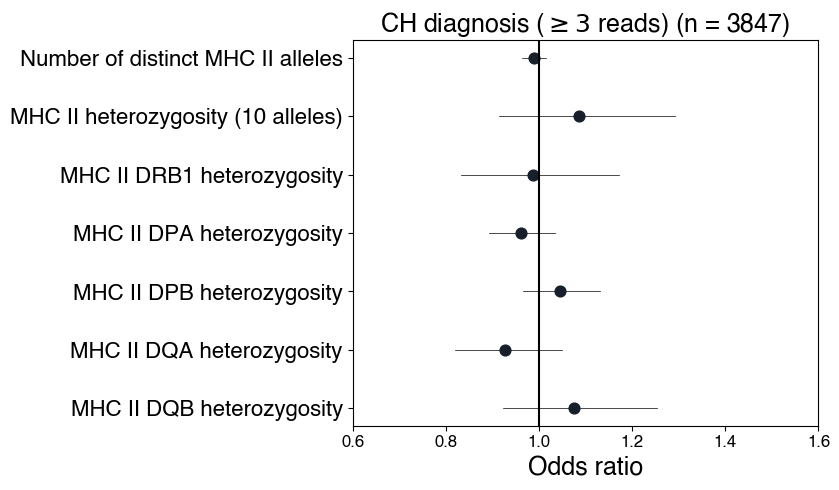

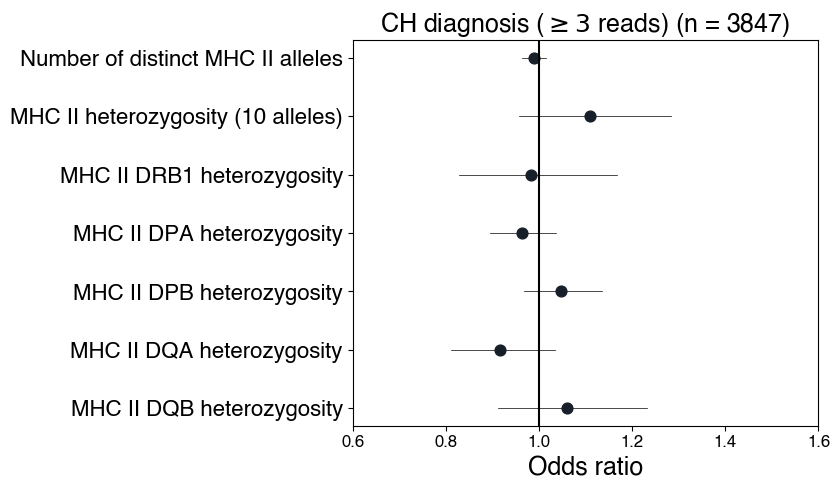

In [41]:
# PLOT (NR OF MHC ALLELES + COMBINED MODEL)

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhcii1_3reads.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla2_features.ch_status_3reads.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 3$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii1_3reads[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii1_3reads[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii1_3reads[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC II alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC II alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC II alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 4 results (MODEL 4 is combined specific MHC classes + overall)
for outcome_label, coef_dict in dict_coefficients_mhcii4_3reads.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii4_3reads[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii4_3reads[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii4_3reads[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC II heterozygosity (10 alleles)', 'MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 15)
    plt.xlim(0.6, 1.6)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    # plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0, fontsize = legend_font, title_fontsize = legend_title, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1d2_log_reg_mhcii_vs_ch_combined_3reads.pdf', bbox_inches='tight')


# PLOT FOR SPLIT MHC LOCI + OVERALL HET
# PLOT (NR OF MHC ALLELES + OVERALL SPLIT MODEL)

# MODEL 1 results
for outcome_label, coef_dict in dict_coefficients_mhcii1_3reads.items():

    descriptor = 'CH diagnosis'
    nr_cases = df_hla2_features.ch_status_3reads.sum() # nr of individuals diagnosed as having CH
    
    plt.figure(figsize=(8.5, 5))
    plt.title(f'{descriptor} ($\geq 3$ reads) (n = {nr_cases})', fontsize = 18)

    # Odds ratio for the intercept term is 1 
    intercept_odds_ratio = 1

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii1_3reads[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii1_3reads[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii1_3reads[outcome_label]

    # Get confidence interval for the feature

    features = ['Number of distinct MHC II alleles']
    
    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[feature])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
        
        if pvalues['Number of distinct MHC II alleles'] < 0.01:
            color = col_001
        elif pvalues['Number of distinct MHC II alleles'] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 2 results (MODEL 2 is overall MHC)
for outcome_label, coef_dict in dict_coefficients_mhcii2_3reads.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii2_3reads[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii2_3reads[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii2_3reads[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC II heterozygosity (10 alleles)'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+1-0.08, i+1+0.08], color = 'black', zorder = 1, linewidth = 0.5)

# MODEL 3 results (MODEL 3 is MHC het for class DRB1, DPA/B, DQA/B)
for outcome_label, coef_dict in dict_coefficients_mhcii3_3reads.items():

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii3_3reads[outcome_label][1:]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii3_3reads[outcome_label][1:]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii3_3reads[outcome_label][1:]

    # Get confidence interval for the feature

    features = ['MHC II DRB1 heterozygosity', 'MHC II DPA heterozygosity', 'MHC II DPB heterozygosity', 'MHC II DQA heterozygosity', 'MHC II DQB heterozygosity'] 

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = np.exp(coefficients[i+3])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = np.exp(float(confint[confint['index'] == feature][0])) 
        upper_ci = np.exp(float(confint[confint['index'] == feature][1]))
    
        if pvalues[feature] < 0.01:
            color = col_001
        elif pvalues[feature] < 0.05:
            color = col_005
        else:
            color = col_ns
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 60, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([lower_ci, lower_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        # plt.plot([upper_ci, upper_ci], [i+2-0.08, i+2+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    # plot formatting 
    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio', fontsize = 18)
    #plt.ylabel('Feature', fontsize = 15)
    plt.xlim(0.6, 1.6) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 16)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = col_001
        elif p_val < 0.05:
            color = col_005
        else:
            color = col_ns
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    # plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0, fontsize = legend_font, title_fontsize = legend_title, frameon = False)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/supplementary_files/sf0/1d2_log_reg_mhcii_vs_ch_split_class_overal_3reads.pdf', bbox_inches='tight')

